### Systematic study

In [21]:
# AutoML
import sys
main_path = '../'
sys.path.append(main_path + 'code/auto_ml')
sys.path.append(main_path + 'code/processing')
sys.path.append(main_path + 'code/functions')
sys.path.append(main_path + 'code/models')
sys.path.append(main_path + 'data')

%matplotlib inline
%reload_ext autoreload
%autoreload 2

from auto_ml import AutoML
from comparator import Comparator

# Sklearn
# Classes has been replaced by continuous variables ?
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

In [106]:
input_dir = '../data/systematic_study_data/'

#datasets = ['iris', 'mushrooms', 'boston', 'adult'] #, mimic
datasets = ['iris']
#labels = ['Species', 'class', 'target', 'income'] #, 'DIED'
labels = ['Species']
generators = ['mg', 'kd', 'rf', 'wgan']

# !!! WGAN: ONLY 5 FEATURES

In [107]:
def regression_score(X_train, y_train, X_test, y_test, scoring='mse'):
    
    model = RandomForestRegressor(n_estimators=50)
    model.fit(X_train, y_train)
    
    if scoring == 'mse':
        return mean_squared_error(y_test, model.predict(X_test)) # MSE
    
    elif scoring == 'r2':
        return model.score(X_test, y_test) # r2
    
    else:
        raise OSError('{} scoring is not taken in charge'.format(scoring))

iris
mg

2 datasets detected: ready for comparison.
Explained variance ratio of the 6 components: 
 [0.71794031 0.16977589 0.05838135 0.03067629 0.01844018 0.00478597]
Explained variance ratio of the 6 components: 
 [0.71660872 0.16337556 0.07230452 0.02560032 0.01885671 0.00325416]


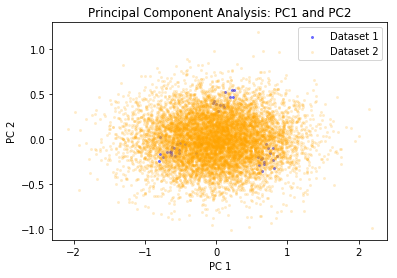

Nearest neighbors metric


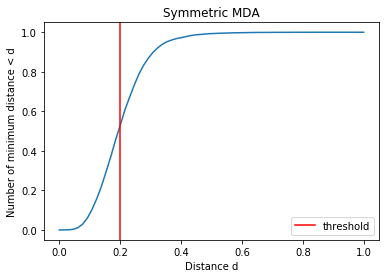

** Privacy: **0.8868236171103554

** Resemblance: **0.9569579746551073

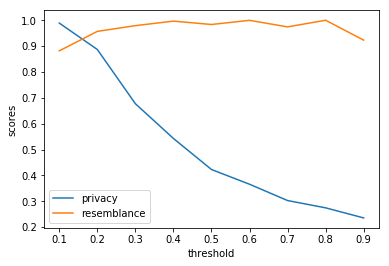

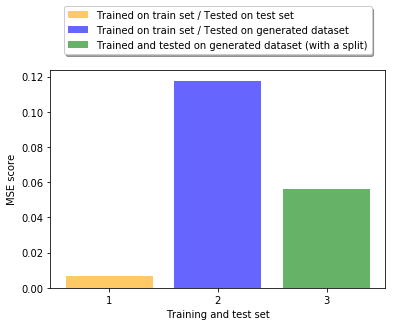

iris
kd

2 datasets detected: ready for comparison.
Explained variance ratio of the 6 components: 
 [0.71794031 0.16977589 0.05838135 0.03067629 0.01844018 0.00478597]
Explained variance ratio of the 6 components: 
 [0.20521791 0.16522955 0.15992721 0.15862319 0.15780663 0.15319551]


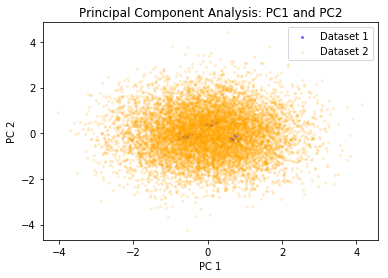

Nearest neighbors metric


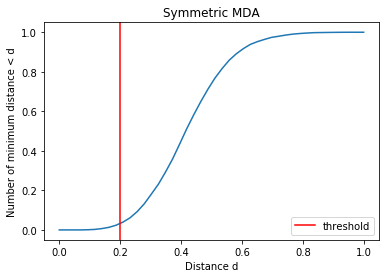

** Privacy: **0.99611785662465

** Resemblance: **0.7203527347886354

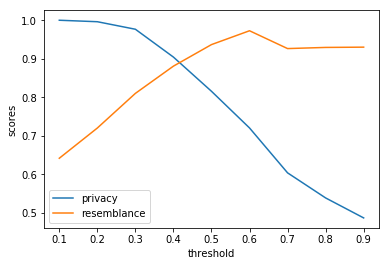

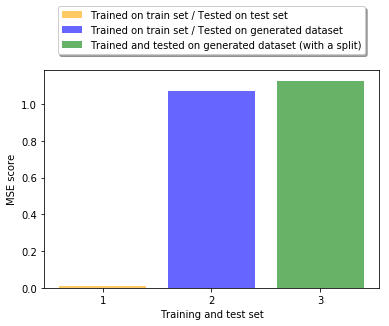

iris
rf

2 datasets detected: ready for comparison.
Explained variance ratio of the 6 components: 
 [0.71794031 0.16977589 0.05838135 0.03067629 0.01844018 0.00478597]
Explained variance ratio of the 6 components: 
 [0.74865519 0.16844381 0.0598398  0.01205271 0.00920878 0.0017997 ]


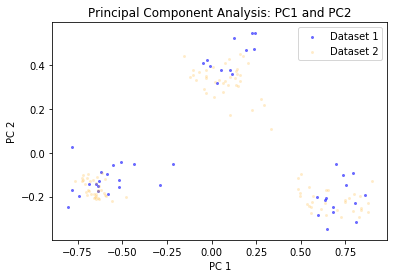

Nearest neighbors metric


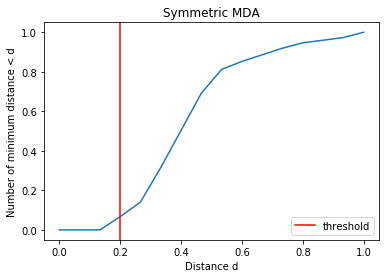

** Privacy: **1.0

** Resemblance: **0.7108501118568233

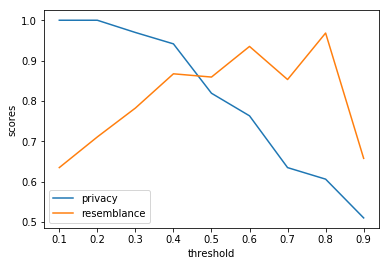

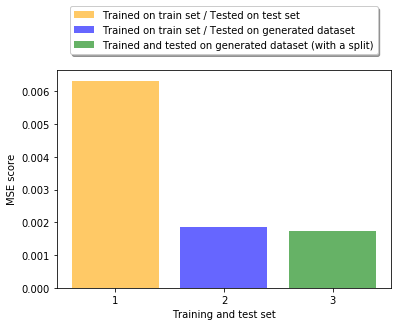

iris
wgan

2 datasets detected: ready for comparison.
Explained variance ratio of the 6 components: 
 [0.71794031 0.16977589 0.05838135 0.03067629 0.01844018 0.00478597]
Explained variance ratio of the 6 components: 
 [0.68824409 0.19215242 0.06470501 0.03711866 0.01289335 0.00488646]


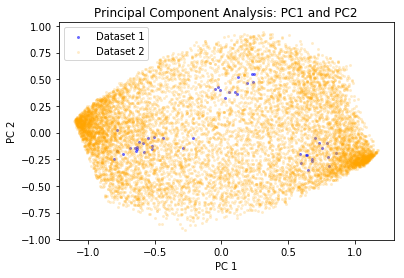

Nearest neighbors metric


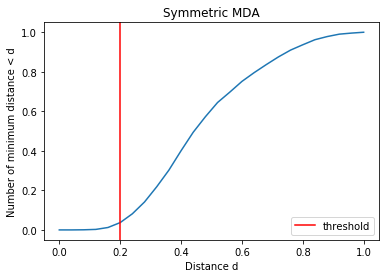

** Privacy: **0.9984122238830759

** Resemblance: **0.6550406909151304

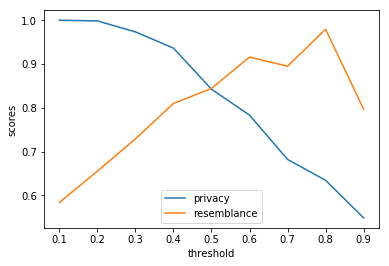

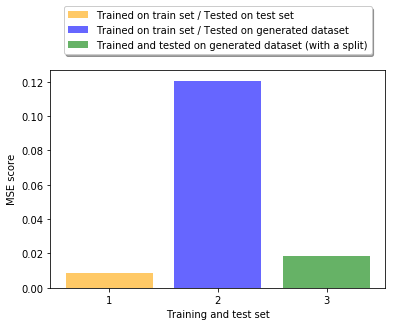

In [110]:
# Loop on datasets
for i, dataset in enumerate(datasets):
    
    # Loop on generative models
    for generator in generators:

        # Intro
        print(dataset)
        print(generator)
        print()
        
        label = labels[i]

        # Train original dataset
        train = AutoML(input_dir + dataset, dataset + '_train_sdv')
        train_data = train.get_data()
        train_y = train_data[label]
        train_X = train_data.drop([label], axis=1)
        
        # Test original dataset
        test = AutoML(input_dir + dataset, dataset + '_test_sdv')
        test_data = test.get_data()
        test_y = test_data[label]
        test_X = test_data.drop([label], axis=1)
        
        # Generated dataset
        gen = AutoML(input_dir + dataset, dataset +'_'+ generator)
        gen_data = gen.get_data()
        gen_y = gen_data[label]
        gen_X = gen_data.drop([label], axis=1)

        # Plots
        comparator = Comparator(test, gen)
        comparator.show_pca()
        comparator.show_mda()
        comparator.show_mda_threshold()
        
        # Regression scores
        scores = []
        
        # train / test
        scores.append(regression_score(train_X, train_y, test_X, test_y))
        
        # train / gen
        scores.append(regression_score(train_X, train_y, gen_X, gen_y))
        
        # gen / gen
        gen_X_train, gen_X_test, gen_y_train, gen_y_test = train_test_split(gen_X, gen_y, test_size=0.3)
        scores.append(regression_score(gen_X_train, gen_y_train, gen_X_test, gen_y_test))
        
        x = [1, 2, 3]
        
        legends = {1:('Trained on train set / Tested on test set','orange'), 
              2:('Trained on train set / Tested on generated dataset','b'), 
              3:('Trained and tested on generated dataset (with a split)','g')}

        ax1 = plt.subplot(111)

        for j in range(len(x)):
            ax1.bar(x[j], scores[j], width=0.8, bottom=0.0, align='center', color=legends[x[j]][1], alpha=0.6, label=legends[x[j]][0])
        
        ax1.set_xticks(x)
        ax1.set_xticklabels([i for i in x])

        ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
                  ncol=1, fancybox=True, shadow=True)

        plt.xlabel('Training and test set')
        plt.ylabel('MSE score')
        
        plt.show()